# EDA Kaggle Competition: Team Integreat

In [ ]:
import pandas as pd
import numpy as np
import plotly
import plotly.plotly as py
from scipy import stats
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

### Loading test

In [ ]:
# test data has 80 variables and 1459 rows
# many missing values
# integers, floats, and objects

test = pd.read_csv('test.csv')

### Loading train

In [ ]:
train = pd.read_csv('train.csv')
train.shape
# train dataset has 1460 rows and 81 variables

#inspecting mean and median
train.describe().loc[['mean','50%','std']]
# median 0 for MasVnrArea, BsmtFinSF2, 2ndFlrSF, WoodDeckSF, EnclosedPorch, MiscVal
# huge sd for LotArea, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 2ndFlrSF, LowQualFinSF, Fireplaces,
#GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal

### Combine test and train

In [ ]:
# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the 'Id' colum since we can not use it as a feature to train our model.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [ ]:
Y_train = train['SalePrice']
X_train = train.drop('SalePrice', axis=1)
X_test = test.copy()

pd.set_option('display.max_columns', X_train.shape[1])
X_train.head()

In [ ]:
all_data = pd.concat([X_train, X_test], ignore_index=True)

### Creating dataset with no missing values: all_data_nomiss

In [ ]:
all_data.isnull().sum().sort_values(ascending=False)

all_data_nomiss = all_data.copy()

for c in all_data_nomiss.columns:
    if all_data_nomiss[c].dtype == 'object':
        all_data_nomiss[c] = all_data_nomiss[c].fillna('Unavailable')
    else:
        all_data_nomiss[c] = all_data_nomiss[c].fillna(0)
        
# alternative:
#all_data_nomiss.select_dtypes(include=['object']).fillna('unavailable')       

### Feature Engineering

The goal is to transform or combine columns to minimize the noise. This will be done by summing numerical values for selected columns, transform ordinal values into type 'category' and/or dummify column values.

**Factorization**

In [ ]:
lis = ['MSSubClass','OverallQual','OverallCond','GarageCars','YrSold']

for c in lis:
    all_data[c] = all_data[c].astype('category')

for c in lis:
    all_data_nomiss[c] = all_data_nomiss[c].astype('category')

**Engineering new columns**

In [ ]:
#only for the nomiss dataset since the original one doesnt have 0 for Fireplaces
all_data_nomiss['Fireplaces'] = np.where(all_data_nomiss['Fireplaces'] == 0, 'No', 'Yes')

all_data_nomiss.Fireplaces.value_counts()

In [ ]:
#Method 2 to achieve the same purpose this time with the loc function.

all_data_nomiss['PoolArea'] = all_data_nomiss['PoolArea'].astype(str)

all_data_nomiss.loc[all_data_nomiss.PoolArea!='0','PoolArea'] = 'Yes'
all_data_nomiss.loc[all_data_nomiss.PoolArea=='0','PoolArea'] = 'No'

all_data_nomiss.PoolArea.value_counts()

**Combining columns**

In [ ]:
#We combine all the total sqf in order to have jsut one variable
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
#and drop the columns
all_data.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], inplace=True, axis=1)

all_data_nomiss['TotalSF'] = all_data_nomiss['TotalBsmtSF'] + all_data_nomiss['1stFlrSF'] + all_data_nomiss['2ndFlrSF']
#and drop the columns
all_data_nomiss.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], inplace=True, axis=1)

#dropped GrLivArea as the same as TotalSF

In [ ]:
#Then we do the same for the baths
all_data['TotalBath'] = all_data['BsmtFullBath'] + all_data['FullBath'] + all_data['HalfBath'] + all_data['BsmtHalfBath']
#and drop the columns
all_data.drop(['HalfBath','FullBath','BsmtHalfBath','BsmtFullBath'], inplace=True, axis=1)

#Then we do the same for the dataset without missing values
all_data_nomiss['TotalBath'] = all_data_nomiss['BsmtFullBath'] + all_data_nomiss['FullBath'] + all_data_nomiss['HalfBath'] + all_data_nomiss['BsmtHalfBath']
#and drop the columns
all_data_nomiss.drop(['HalfBath','FullBath','BsmtHalfBath','BsmtFullBath'], inplace=True, axis=1)

In [ ]:
#lets aggreagete all the porchs sf into one

all_data['TotalPorchSF']  = all_data['WoodDeckSF'] + all_data['OpenPorchSF'] + all_data['EnclosedPorch']  + all_data['3SsnPorch'] + all_data['ScreenPorch']
all_data.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'], inplace=True, axis=1)

#same for datatset without missing values

all_data_nomiss['TotalPorchSF']  = all_data_nomiss['WoodDeckSF'] + all_data_nomiss['OpenPorchSF'] + all_data_nomiss['EnclosedPorch']  + all_data_nomiss['3SsnPorch'] + all_data_nomiss['ScreenPorch']
all_data_nomiss.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'], inplace=True, axis=1)

**Ordinal features**

In [ ]:
ord_cols = ['ExterQual', 'ExterCond','BsmtCond','HeatingQC', 'KitchenQual', 
           'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

ord_dic = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1, 'Unavailable':0}

In [ ]:
# all data
all_data_ord = all_data.copy()

for col in ord_cols:
    all_data_ord[col] = all_data_ord[col].map(lambda x: ord_dic.get(x, 0))
all_data_ord.head()

In [ ]:
# all data without NA
all_data_ord_nomiss = all_data_nomiss.copy()

for col in ord_cols:
    all_data_ord_nomiss[col] = all_data_ord_nomiss[col].map(lambda x: ord_dic.get(x, 0))
all_data_ord_nomiss.head()

** Label Encoder to convert all categorical values into numerical**

In [ ]:
from sklearn.preprocessing import LabelEncoder

all_data_label_nomiss = all_data_ord_nomiss.copy()

for c in all_data_label_nomiss:
    if all_data_label_nomiss[c].dtype == 'object':
        le = LabelEncoder()
        # Need to convert the column type to string in order to encode missing values
        all_data_label_nomiss[c] = le.fit_transform(all_data_label_nomiss[c].astype(str))

In [ ]:
from sklearn.preprocessing import LabelEncoder

all_data_label = all_data_ord.copy()

for c in all_data_label:
    if all_data_label[c].dtype == 'object':
        le = LabelEncoder()
        # Need to convert the column type to string in order to encode missing values
        all_data_label[c] = le.fit_transform(all_data_label[c].astype(str))

In [ ]:
#pd.set_option('display.max_columns', all_data.shape[1])
all_data_label_nomiss.head()

**Splitting dataset into train and test again**

The row number remain the same but pre-processing got rid of 9 columns (yeahi)

In [ ]:
trainset = len(X_train)
X_train_preprocessed = all_data_label_nomiss[:trainset]
X_test_preprocessed = all_data_label_nomiss[trainset:]

print(X_train_preprocessed.shape)
print(X_train.shape)

print(X_test_preprocessed.shape)
print(X_test.shape)

**Standardization**

We apply standardization to selected numerical columns which do not represent ordinal features or have been transformed by LabelEncoder to make sure that huge standard deviations dont affect ML models but remain information about outliers

In [ ]:
from sklearn.preprocessing import StandardScaler
columns_transform = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','LowQualFinSF','GrLivArea','GarageArea','PoolArea']
X_train_std = X_train_preprocessed.copy()
X_test_std = X_test_preprocessed.copy()

std = StandardScaler()

X_train_std.loc[:,columns_transform] = std.fit_transform(X_train_preprocessed.loc[:,columns_transform])
X_test_std.loc[:,columns_transform] = std.transform(X_test_preprocessed.loc[:,columns_transform])

print(X_train_std.shape)
print(X_test_std.shape)

In [ ]:
X_train_std.columns[0:]

## Feature selection

Feature selection can be done by applying many different models. Here, I use RandomForest and PCA.

In [ ]:
# import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

feat_labels = X_train_std.columns[0:]

forest = RandomForestClassifier(n_estimators = 500, random_state=1)
forest.fit(X_train_std, Y_train)

In [ ]:
#save values of importance and indices of the columns
importances = forest.feature_importances_
indices = np.argsort(importances)
indices

In [ ]:
# print the columns and importance
for feature in range(X_train_std.shape[1]):
    print("%2d) %-*s %feature" % (feature + 1, 30, feat_labels[indices[feature]],
                                 importances[indices[feature]]))

In [ ]:
#visualize result with all columns
from matplotlib import cm
color = cm.inferno_r(np.linspace(.4,.8, 69))

plt.figure(figsize=(20,20))
plt.title('Feature Importance')

x = plt.barh(range(X_train_std.shape[1]), importances[indices], align='center', color=color)
x = plt.yticks(range(X_train_std.shape[1]), feat_labels, rotation = 0, size=12)
x = plt.ylim([-1, X_train_std.shape[1]])

In [105]:
# set threshold as mean to pick features
from sklearn.feature_selection import SelectFromModel
importances2 = forest.feature_importances_
indices2 = np.argsort(importances2)[::-1]

sfm = SelectFromModel(forest, prefit=True, threshold=None)
X_selected = sfm.transform(X_train_std)


for feature in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (feature + 1, 30, feat_labels[indices2[feature]],
                                 importances2[indices2[feature]]))
    
#plt.figure(figsize=(20,20))
#plt.title('Feature Importance')

#x = plt.barh(range(X_selected.shape[1]), importances[indices], align='center', color=color)
#x = plt.yticks(range(X_selected.shape[1]), feat_labels, rotation = 0, size=15)


 1) TotalSF                        0.043119
 2) LotArea                        0.042288
 3) GrLivArea                      0.042121
 4) BsmtUnfSF                      0.039779
 5) GarageArea                     0.039006
 6) TotalPorchSF                   0.037674
 7) LotFrontage                    0.034428
 8) YearBuilt                      0.034312
 9) MoSold                         0.033754
10) GarageYrBlt                    0.032754
11) BsmtFinSF1                     0.032569
12) YearRemodAdd                   0.031674
13) Neighborhood                   0.026738
14) YrSold                         0.024261
15) MasVnrArea                     0.023815
16) TotRmsAbvGrd                   0.023097
17) Exterior2nd                    0.020522
18) Exterior1st                    0.019612
19) OverallQual                    0.019315
20) BsmtFinType1                   0.017820
21) OverallCond                    0.016642
22) MSSubClass                     0.015848
23) BedroomAbvGr                

In [157]:
from  sklearn.linear_model import LinearRegression
from sklearn import linear_model

In [158]:
lasso = linear_model.Lasso(alpha=1)
alphas_lasso = np.logspace(-4, 0, 100)
coef_lasso = []
for i in alphas_lasso:
    lasso.set_params(alpha=i).fit(X_train_std,Y_train)
    coef_lasso.append(lasso.coef_)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause p

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause p

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause p

In [161]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
alpha_vals = np.logspace(-4, 4, 1000)

model_lasso_5CV = LassoCV(alphas = alpha_vals, normalize=True, cv=5).fit(X_train_std, Y_train)

In [163]:
lasso = linear_model.Lasso(alpha=1)
alphas_lasso = np.logspace(-4, 0, 100)
coef_lasso = []
for i in alphas_lasso:
    lasso.set_params(alpha=i).fit(X_train_std,Y_train)
    coef_lasso.append(lasso.coef_)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause p

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause p

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause p

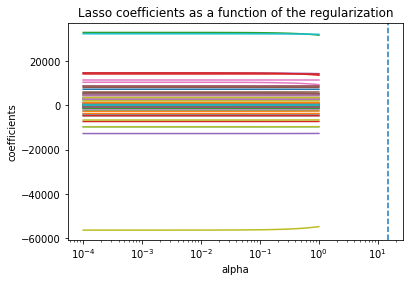

In [164]:
plt.figure(figsize=(20,20))
columns = X_train_std.columns
df_coef = pd.DataFrame(coef_lasso, index=alphas_lasso, columns=columns)
title = 'Lasso coefficients as a function of the regularization'
df_coef.plot(logx=True, title=title, legend=False)
plt.xlabel('alpha')
plt.ylabel('coefficients')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.axvline(x=model_lasso_5CV.alpha_,ls="dashed")
#plt.savefig('./lasso.png', bbox_inches='tight', dpi = 300)

## Pipelines

**Linear regression**

In [118]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(SelectFromModel(forest, threshold=None),
                        LinearRegression())
pipe_lr.fit(X_train_std, Y_train)
y_pred = pipe_lr.predict(X_test_std)

print('Test Accuracy: %.3f' %pipe_lr.score(X_train_std, Y_train))


Test Accuracy: 0.815


In [121]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(
                        LinearRegression())
pipe_lr.fit(X_train_std, Y_train)
y_pred = pipe_lr.predict(X_test_std)

print('Test Accuracy: %.3f' %pipe_lr.score(X_train_std, Y_train))


Test Accuracy: 0.846


In [122]:
# Create linear regression object
from sklearn.linear_model import LinearRegression
linear = LinearRegression()

# Train the model using the training sets and check score
# x_train is array, y_train is column vector
linear.fit(X_train_std, Y_train)
linear.score(X_train_std, Y_train)

0.8461826991072153

In [154]:
from sklearn.tree import DecisionTreeClassifier

fr = DecisionTreeClassifier(random_state=1)
fr.fit(X_train_std, Y_train)
fr.score(X_train_std, Y_train)

1.0

In [152]:
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

dot_data = export_graphviz(fr, filled=True, rounded=True,out_file=None)

graph=graph_from_dot_data(dot_data)

graph.write_png('tree.png')

True

**Cross validation**

In [123]:
# stratified cross_validation scorer
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator = pipe_lr, X=X_train_std,
                        y = Y_train,
                        cv=10,
                        n_jobs=1)

print('CV accuracy scores: %s' %(scores))

print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

CV accuracy scores: [0.88652513 0.8818416  0.89486239 0.73723249 0.85276331 0.83603979
 0.84416542 0.85492084 0.5212197  0.86151571]
CV accuracy: 0.817 +/- 0.107


**Learning curves**

In [124]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

test_std

array([10.29979383,  0.10123863,  0.2981897 ,  0.09165274,  0.09533915,
        0.10160113,  0.1131125 ,  0.1137455 ,  0.32785718,  0.10712076])

Text(0.5,1,'Example of a horrible model')

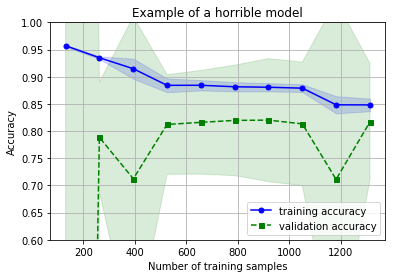

In [125]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores= learning_curve(estimator=pipe_lr,
                                                      X=X_train_std,
                                                      y=Y_train,
                                                      train_sizes=np.linspace(0.1,1.0,10),
                                                      cv=10,
                                                      n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='b', marker='o', markersize='5',label='training accuracy')

plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='b')

plt.plot(train_sizes, test_mean, color='green', linestyle='--',marker='s', markersize=5, label='validation accuracy')

plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.6, 1.0])
plt.title('Example of a horrible model')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from math import sqrt
#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create KNeighbors classifier object model 

model = KNeighborsClassifier(n_neighbors = 38) # default value for n_neighbors is 5
# Train the model using the training sets and check score

model.fit(X_train_std, Y_train)
model.score(X_train_std, Y_train)
#Predict Output
#predicted= model.predict(x_test)

In [ ]:
#Import other necessary libraries like pandas, numpy...
from sklearn import tree

#Assumed you have X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
#Create tree object 
#for classification, here you can change the algorithm as gini or entropy (information gain) (default = gini) 
model = tree.DecisionTreeClassifier()  # classification


# Train the model using the training sets and check score
model.fit(X_train_std, Y_train)
model.score(X_train_std, Y_train)

In [ ]:
clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=1.0)
lr.fit(X_train_std, Y_train)
#print('Training accuracy:', lr.score(X_train_std, y_train))



### Outlier inspection due to large std

### Scatterplot for selected numerical columns

In [ ]:
# investigate relationships
train.describe().columns
cols = ['LotArea','OverallQual','OverallCond','TotalBsmtSF','GarageArea', 'SalePrice']
sns.pairplot(train[cols], size=2)

#SalePrice right-skewed - log or box cox transformation
#TotalBsmtSF and GarageArea normally distributed

#Correlations SalePrice: TotalBsmtSF, GaraArea, OverallQual
#Multicollinearity: OverallQual and TotalBsmtSF, TotalBsmtSF and GarageArea

In [ ]:
cor = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.5)
heat = sns.heatmap(cor, cbar=True,
                  annot=True,
                  square=True,
                  fmt='.2f',
                  annot_kws={'size':15},
                  yticklabels=cols,
                  xticklabels=cols)

#SalePrice correlate with: GarageArea, TotalSF